# 모델1 : 전복

## 모델구성
- 레거시모델과 가장 유사하게 모델 구성
- 성별 원핫인코딩
- 은닉층2개
- 노드개수 = 특성 수(10개)

## 결과
### 성능
- Test Loss : 4.684 / Test Accuracy : 0.756

### 평가
- 100에포크 이후로 성능이 오르지 않아 조기종료 되었음
- 훈련점수와 검증점수의 차이가 없어 과소적합이 의심됨
- 성능을 올리기 위하여 복잡도를 증가시키는 방향의 개선 필요

In [1]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [2]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/Regression_data.csv'
EPOCHS = 1000
MB_SIZE = 1024

In [3]:
def load_data(csv_path, TRAIN_RATIO=0.8):
    
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 성별 원핫 인코딩
    df=pd.get_dummies(df,columns=['Sex'])
    
    # 학습 데이터 분리
    X = df.drop('Rings', axis=1)
    y = df['Rings'].astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    return df, X, y, X_train, X_test, y_train, y_test
    
df, X, y, X_train, X_test, y_train, y_test = load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3341, 10) (836, 10) (3341,) (836,)


In [4]:
X_train.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
count,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000
mean,0.523174,0.407287,0.139611,0.825669,0.357513,0.180396,0.237986,0.314576,0.317869,0.367555
std,0.119784,0.099014,0.042640,0.488083,0.221129,0.109401,0.138090,0.464416,0.465718,0.482211
min,0.110000,0.090000,0.000000,0.008000,0.002500,0.000500,0.003000,0.000000,0.000000,0.000000
25%,0.450000,0.345000,0.115000,0.441000,0.185000,0.092000,0.130000,0.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.334000,0.171500,0.235000,0.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.146000,0.498500,0.252500,0.325000,1.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.779500,1.488000,0.760000,1.005000,1.000000,1.000000,1.000000


In [5]:
def get_model(shape, node_n=4, dout=0.01):
    inputs  = keras.Input(shape=shape)
    
    x = keras.layers.Dense(node_n)(inputs)
    x = keras.layers.Dense(node_n)(x)
    
    outputs = keras.layers.Dense(1)(x)
    model   = keras.Model(inputs, outputs, name='Abalone_Model')
    return model

model = get_model(len(X_train.columns), node_n=10, dout=0.01)
print(model.summary())
    

Model: "Abalone_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________
None


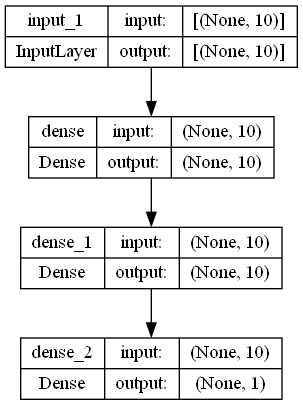

In [6]:
keras.utils.plot_model(model, show_shapes=True, to_file='model1_model.png')

In [7]:
class EvalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="accuracy", **kwargs):
        super(EvalAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name=name, initializer="zeros")

    def update_state(self, y_true, y_predict, sample_weight=None):
        value = tf.abs((y_predict - y_true) / y_true)
        self.correct.assign(tf.reduce_mean(value))

    def result(self):
        return 1 - self.correct

    def reset_state(self):
        self.correct.assign(0.)

class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

In [8]:
model.compile(
        optimizer=keras.optimizers.Adam(0.01),
        loss=keras.losses.MeanSquaredError(),
        metrics=[EvalAccuracy()]
        )

# 얼리스타핑
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy'
                                        , min_delta=0.000001
                                        , patience=EPOCHS//5)

# 모델 저장
checkpoint_path = 'model1.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='val_accuracy'
                                        , verbose=0
                                        , save_best_only=True
                                        , save_weights_only=True)

# 모델 학습
history = model.fit(X_train, y_train
                    , batch_size=MB_SIZE
                    , validation_split = 0.2
                    , verbose=0
                    , epochs=EPOCHS
                    , callbacks=[earlystop, checkpoint, CustomCallback()]
                    )

Starting training


c:\Users\leeyeonjun85\.conda\envs\p310_1\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric EvalAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 170 / 180 / 190 / 
200 / 210 / 220 / 230 / 240 / 250 / 260 / 270 / 280 / 290 / 
300 / 310 / 320 / 330 / 340 / 350 / 360 / 370 / 380 / 390 / 
400 / 410 / 420 / 430 / 440 / 450 / 460 / 470 / 480 / 490 / 
500 / 510 / 520 / End training


In [14]:
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss : {loss:.3f} / Test Accuracy : {accuracy:.3f}')

27/27 [==============================] - 0s 5ms/step - loss: 4.6845 - accuracy: 0.7564
Test Loss : 4.684 / Test Accuracy : 0.756


c:\Users\leeyeonjun85\.conda\envs\p310_1\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric EvalAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


In [10]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model1.json')

with open('model1.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,accuracy,val_loss,val_accuracy
0,99.029037,0.109058,83.875305,0.152323
1,77.669609,0.247546,63.545090,0.288816
2,57.433075,0.398648,43.233803,0.453770
3,37.418915,0.580813,24.251234,0.651226
4,20.056648,0.760284,11.970469,0.771322
...,...,...,...,...
524,4.864634,0.841917,5.295318,0.840097
525,4.879333,0.844289,5.337078,0.835710
526,4.885193,0.834044,5.284296,0.843455
527,4.892731,0.845065,5.294801,0.839728


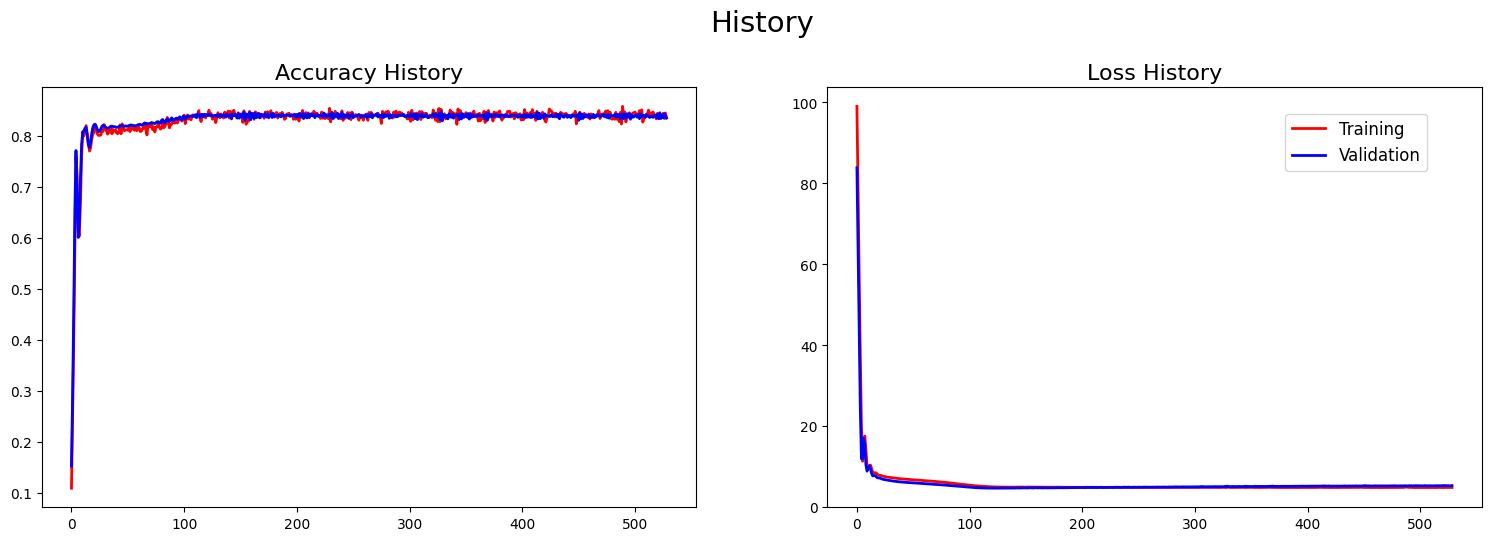

In [11]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Accuracy History', fontsize = 16, y = 1)
plt.plot(history.history["accuracy"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_accuracy"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model1_history.png', dpi=80, bbox_inches='tight')